In [677]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [678]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [679]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357104 entries, 0 to 2357103
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.0 MB


# reduce to 1 million events

In [680]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [681]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,3185,1.13,3.185
1,3207,1.12,3.207
2,6133,0.59,6.133
3,3173,1.13,3.173
4,3178,1.13,3.178
...,...,...,...
999995,30066,0.12,30.066
999996,29955,0.12,29.955
999997,30041,0.12,30.041
999998,29894,0.12,29.894


### conversion Interval -> kWh

In [682]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,3185,1.13,3.185,1130.298273
1,3207,1.12,3.207,1122.544434
2,6133,0.59,6.133,586.988423
3,3173,1.13,3.173,1134.572959
4,3178,1.13,3.178,1132.787917
...,...,...,...,...
999995,30066,0.12,30.066,119.736580
999996,29955,0.12,29.955,120.180270
999997,30041,0.12,30.041,119.836224
999998,29894,0.12,29.894,120.425503


### Cumul Total interval

In [683]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [684]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26920085647000

### Calcul de la date de base = now - cumul_interval

In [685]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 25, 18, 55, 3, 959128)

In [686]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [687]:
conso_data.iloc[0]


Interval     3185.000000
kWh             1.130000
sec             3.185000
Wh           1130.298273
cumul(ms)    3185.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [688]:
base

datetime.datetime(2024, 8, 25, 18, 55, 3, 959128)

## créer les dates

In [689]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-25 18:55:07.144128
1        2024-08-25 18:55:10.351128
2        2024-08-25 18:55:16.484128
3        2024-08-25 18:55:19.657128
4        2024-08-25 18:55:22.835128
                    ...            
999995   2025-07-03 08:41:09.815128
999996   2025-07-03 08:41:39.770128
999997   2025-07-03 08:42:09.811128
999998   2025-07-03 08:42:39.705128
999999   2025-07-03 08:43:09.606128
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [690]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,3185,1.13,3.185,1130.298273,3185,2024-08-25 18:55:07.144128,25/08/24
1,3207,1.12,3.207,1122.544434,6392,2024-08-25 18:55:10.351128,25/08/24
2,6133,0.59,6.133,586.988423,12525,2024-08-25 18:55:16.484128,25/08/24
3,3173,1.13,3.173,1134.572959,15698,2024-08-25 18:55:19.657128,25/08/24
4,3178,1.13,3.178,1132.787917,18876,2024-08-25 18:55:22.835128,25/08/24
...,...,...,...,...,...,...,...
999995,30066,0.12,30.066,119.736580,26919965856,2025-07-03 08:41:09.815128,03/07/25
999996,29955,0.12,29.955,120.180270,26919995811,2025-07-03 08:41:39.770128,03/07/25
999997,30041,0.12,30.041,119.836224,26920025852,2025-07-03 08:42:09.811128,03/07/25
999998,29894,0.12,29.894,120.425503,26920055746,2025-07-03 08:42:39.705128,03/07/25


### save conso_data with dates

In [691]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [692]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('03/07/25', 3, 7, 2025, '08:43:32')

In [693]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [694]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 999034 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   966 non-null    int64         
 1   kWh        966 non-null    float64       
 2   sec        966 non-null    float64       
 3   Wh         966 non-null    float64       
 4   cumul(ms)  966 non-null    int64         
 5   dates      966 non-null    datetime64[ns]
 6   days       966 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 60.4+ KB


In [695]:
end = time.time()
print(end - start)

28.123977422714233


### grouped by days

In [696]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [697]:
data = list(df_grp['kWh'])
print(data)

[1.078, 3.832, 3.95, 3.749, 4.039, 3.606, 3.703, 3.537, 3.634, 3.512, 4.146, 3.523, 3.66, 3.585, 3.154, 2.604, 1.798, 1.793, 1.795, 1.794, 2.427, 1.911, 1.787, 1.793, 1.788, 1.82, 1.82, 1.817, 1.815, 1.818, 1.817, 1.815, 1.817, 1.785, 1.787, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.794, 1.802, 1.796, 1.8, 1.799, 1.786, 1.788, 1.786, 1.791, 1.796, 1.791, 1.8, 1.804, 1.793, 1.801, 1.799, 2.667, 4.0, 3.674, 3.903, 3.099, 3.391, 4.095, 3.393, 3.451, 4.012, 3.331, 3.719, 3.575, 3.982, 3.202, 3.315, 3.419, 4.075, 3.28, 3.381, 3.824, 3.225, 3.555, 3.297, 3.904, 3.352, 3.431, 3.732, 4.421, 3.602, 3.867, 3.399, 4.176, 3.506, 3.435, 3.309, 3.85, 3.683, 4.119, 3.21, 3.744, 3.785, 3.173, 3.679, 3.666, 3.37, 3.882, 3.189, 4.077, 3.425, 3.743, 4.045, 3.412, 4.528, 3.253, 3.482, 3.095, 3.217, 3.439, 3.353, 3.397, 3.457, 4.633, 4.513, 3.235, 3.439, 3.652, 3.955, 3.518, 4.452, 4.177, 4.121, 3.741, 3.771, 3.521, 3.543, 4.38, 3.17, 3.374, 3.395, 3.451, 3.61, 3.383, 4.557, 3.26, 3.789, 3.244, 3.6

In [698]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [699]:
end = time.time()
print(end - start)

29.16963291168213


### plot function by day
#### show('dd/mm/yy')

In [700]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


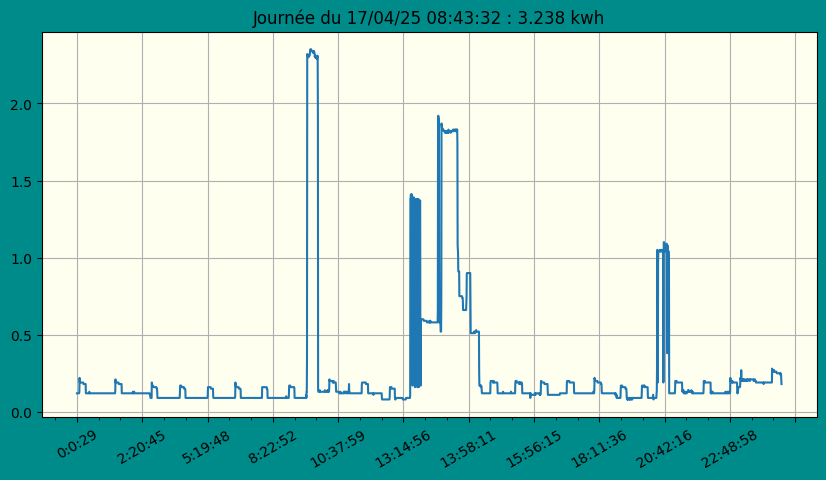

In [701]:
show('17/04/25')

In [702]:
end = time.time()
print(end - start)

30.576114416122437


### 1 kWh window in data of one day
#### df = conso_day

In [703]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999034,18118,0.20,18.118,198.697428,26888707043,2025-07-03 00:00:11.002128,03/07/25
999035,18123,0.20,18.123,198.642609,26888725166,2025-07-03 00:00:29.125128,03/07/25
999036,18159,0.20,18.159,198.248802,26888743325,2025-07-03 00:00:47.284128,03/07/25
999037,18227,0.20,18.227,197.509190,26888761552,2025-07-03 00:01:05.511128,03/07/25
999038,18291,0.20,18.291,196.818107,26888779843,2025-07-03 00:01:23.802128,03/07/25
...,...,...,...,...,...,...,...
999995,30066,0.12,30.066,119.736580,26919965856,2025-07-03 08:41:09.815128,03/07/25
999996,29955,0.12,29.955,120.180270,26919995811,2025-07-03 08:41:39.770128,03/07/25
999997,30041,0.12,30.041,119.836224,26920025852,2025-07-03 08:42:09.811128,03/07/25
999998,29894,0.12,29.894,120.425503,26920055746,2025-07-03 08:42:39.705128,03/07/25


In [704]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [705]:
df = conso_day
len(df)

966

In [706]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-03 00:00:11.002128	2025-07-03 08:43:09.606128	8h 42m 58s 	966


In [707]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.298436
dtype: float64

In [708]:
end = time.time()
print(end - start)

31.21926474571228


## mean for data grouped by days

In [709]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.194888
dtype: float64

In [710]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(0.966)

# conso by date


In [711]:
# select day
day = today

#day = '16/08/24'
day

'03/07/25'

In [712]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999034,18118,0.20,18.118,198.697428,26888707043,2025-07-03 00:00:11.002128,03/07/25
999035,18123,0.20,18.123,198.642609,26888725166,2025-07-03 00:00:29.125128,03/07/25
999036,18159,0.20,18.159,198.248802,26888743325,2025-07-03 00:00:47.284128,03/07/25
999037,18227,0.20,18.227,197.509190,26888761552,2025-07-03 00:01:05.511128,03/07/25
999038,18291,0.20,18.291,196.818107,26888779843,2025-07-03 00:01:23.802128,03/07/25
...,...,...,...,...,...,...,...
999995,30066,0.12,30.066,119.736580,26919965856,2025-07-03 08:41:09.815128,03/07/25
999996,29955,0.12,29.955,120.180270,26919995811,2025-07-03 08:41:39.770128,03/07/25
999997,30041,0.12,30.041,119.836224,26920025852,2025-07-03 08:42:09.811128,03/07/25
999998,29894,0.12,29.894,120.425503,26920055746,2025-07-03 08:42:39.705128,03/07/25


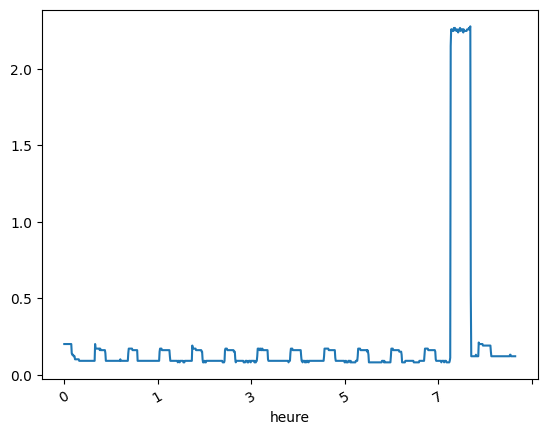

In [713]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [714]:
end = time.time()
print(end - start)

31.907281637191772


### grouped by 'heure'

In [715]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 999034 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   966 non-null    int64         
 1   kWh        966 non-null    float64       
 2   sec        966 non-null    float64       
 3   Wh         966 non-null    float64       
 4   cumul(ms)  966 non-null    int64         
 5   dates      966 non-null    datetime64[ns]
 6   days       966 non-null    object        
 7   heure      966 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 67.9+ KB


In [716]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999034,18118,0.20,18.118,198.697428,26888707043,2025-07-03 00:00:11.002128,03/07/25
999035,18123,0.20,18.123,198.642609,26888725166,2025-07-03 00:00:29.125128,03/07/25
999036,18159,0.20,18.159,198.248802,26888743325,2025-07-03 00:00:47.284128,03/07/25
999037,18227,0.20,18.227,197.509190,26888761552,2025-07-03 00:01:05.511128,03/07/25
999038,18291,0.20,18.291,196.818107,26888779843,2025-07-03 00:01:23.802128,03/07/25
...,...,...,...,...,...,...,...
999995,30066,0.12,30.066,119.736580,26919965856,2025-07-03 08:41:09.815128,03/07/25
999996,29955,0.12,29.955,120.180270,26919995811,2025-07-03 08:41:39.770128,03/07/25
999997,30041,0.12,30.041,119.836224,26920025852,2025-07-03 08:42:09.811128,03/07/25
999998,29894,0.12,29.894,120.425503,26920055746,2025-07-03 08:42:39.705128,03/07/25


In [717]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [718]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    114
1    106
2    101
3    101
4    103
5     98
6    107
7    105
8    131
Name: kWh, dtype: int64

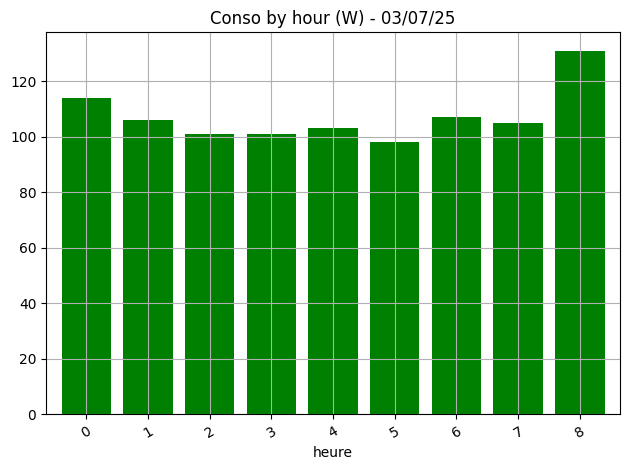

In [719]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [720]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 25/08/24 to 03/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     313 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [721]:
# give the periods of 1 kwh in a day
period()

2025-07-03 00:00:11.002128	2025-07-03 08:43:09.606128	8h 42m 58s 	966


In [722]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [723]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [724]:
df_grp.mean()


kWh    3.194888
dtype: float64

In [725]:
df_grp.head()


,kWh
days,
25/08/24,1.078
26/08/24,3.832
27/08/24,3.950
28/08/24,3.749
29/08/24,4.039


In [726]:
df_grp.tail()


,kWh
days,
29/06/25,2.290
30/06/25,2.773
01/07/25,3.652
02/07/25,3.192
03/07/25,0.966


In [727]:
end = time.time()
print(end - start)

33.13839054107666


# plot les 100 derniers jours


In [728]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.01607
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

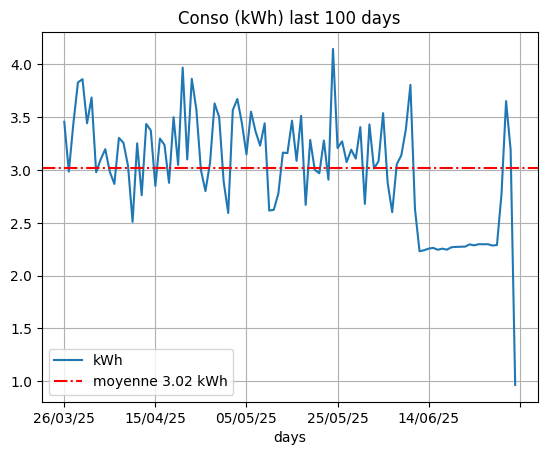

In [729]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [730]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,0.966
max,4.146


In [731]:
end = time.time()
print(end - start)

34.04025840759277


In [732]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('03/06/25', '28/06/25')

In [733]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.620367
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

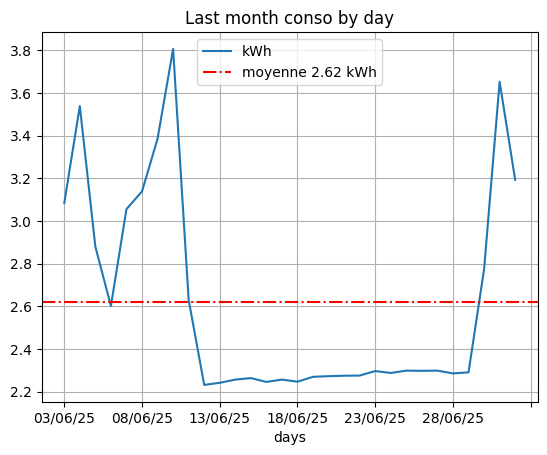

In [734]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [735]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 10/06/25 3.806
Min : 12/06/25 2.231


# Temps de conso par tranche de 1 kWh

In [736]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


1
2025-07-03 00:00:11.002128	2025-07-03 08:43:09.606128	8h 42m 58s 	966


In [737]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('08:43:32', 0.966, 966)

In [738]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 999034 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   966 non-null    int64         
 1   kWh        966 non-null    float64       
 2   sec        966 non-null    float64       
 3   Wh         966 non-null    float64       
 4   cumul(ms)  966 non-null    int64         
 5   dates      966 non-null    datetime64[ns]
 6   days       966 non-null    object        
 7   heure      966 non-null    object        
 8   hours      966 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 75.5+ KB


In [739]:
conso_hours['heure'], conso_hours['hours']

(999034    0
 999035    0
 999036    0
 999037    0
 999038    0
          ..
 999995    8
 999996    8
 999997    8
 999998    8
 999999    8
 Name: heure, Length: 966, dtype: object,
 999034    00
 999035    00
 999036    00
 999037    00
 999038    00
           ..
 999995    08
 999996    08
 999997    08
 999998    08
 999999    08
 Name: hours, Length: 966, dtype: object)

In [740]:
end = time.time()
print(end - start)

34.92644715309143


# select number of days to display


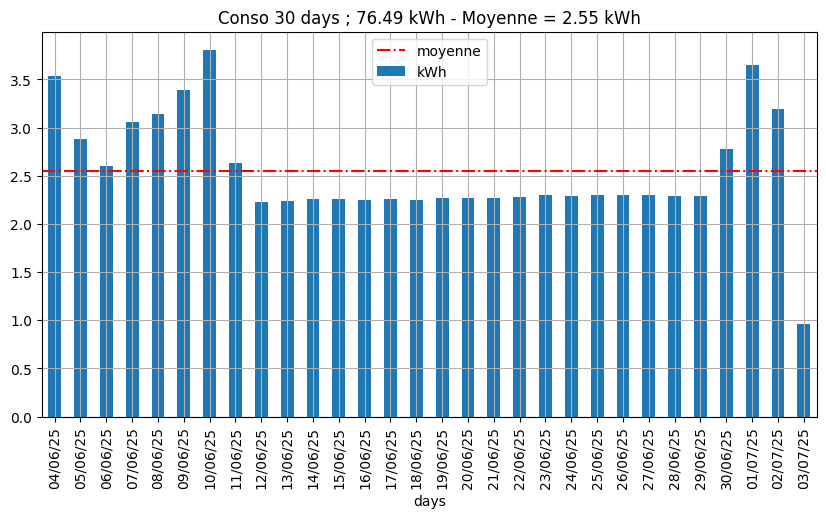

In [741]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


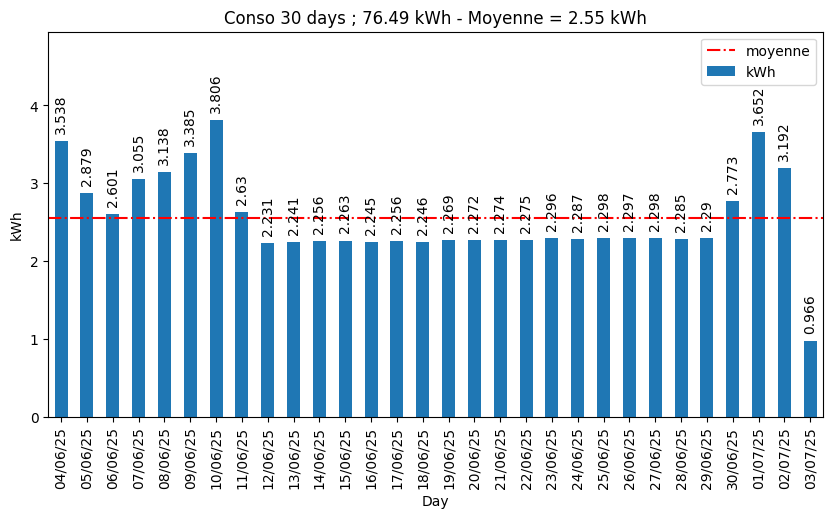

In [742]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [743]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
04/06/25    3.538
05/06/25    2.879
06/06/25    2.601
07/06/25    3.055
08/06/25    3.138
09/06/25    3.385
10/06/25    3.806
11/06/25    2.630
12/06/25    2.231
13/06/25    2.241
14/06/25    2.256
15/06/25    2.263
16/06/25    2.245
17/06/25    2.256
18/06/25    2.246
19/06/25    2.269
20/06/25    2.272
21/06/25    2.274
22/06/25    2.275
23/06/25    2.296
24/06/25    2.287
25/06/25    2.298
26/06/25    2.297
27/06/25    2.298
28/06/25    2.285
29/06/25    2.290
30/06/25    2.773
01/07/25    3.652
02/07/25    3.192
03/07/25    0.966
Name: kWh, dtype: float64

In [744]:
x_labels=df_grp.tail(span).index
x_labels

Index(['04/06/25', '05/06/25', '06/06/25', '07/06/25', '08/06/25', '09/06/25',
       '10/06/25', '11/06/25', '12/06/25', '13/06/25', '14/06/25', '15/06/25',
       '16/06/25', '17/06/25', '18/06/25', '19/06/25', '20/06/25', '21/06/25',
       '22/06/25', '23/06/25', '24/06/25', '25/06/25', '26/06/25', '27/06/25',
       '28/06/25', '29/06/25', '30/06/25', '01/07/25', '02/07/25', '03/07/25'],
      dtype='object', name='days')

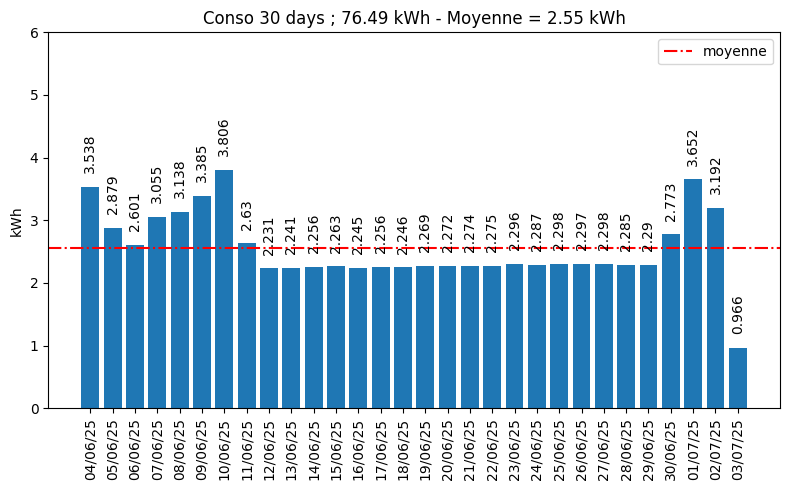

In [745]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [746]:
end = time.time()
print(end - start)

38.48502993583679


In [747]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

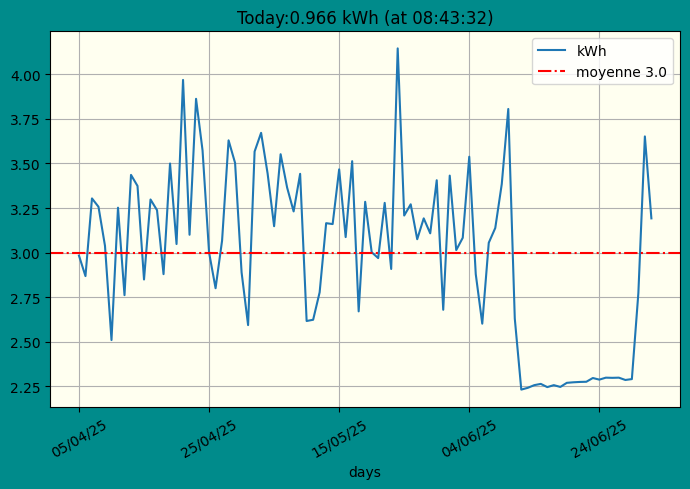

In [748]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

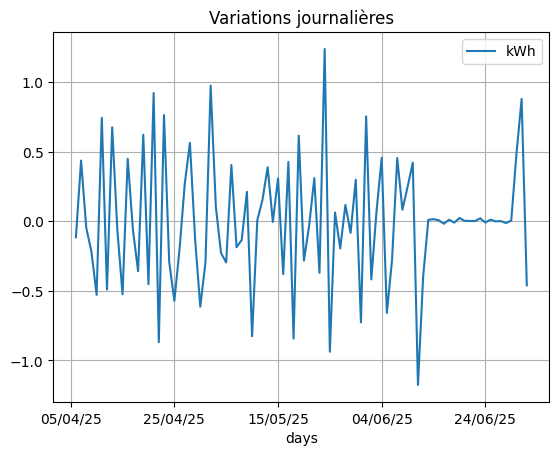

In [749]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [750]:
end = time.time()
print(end - start)

39.74133896827698


# Data from 21/08/23

In [751]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,3185,1.13,3.185,1130.298273,3185,2024-08-25 18:55:07.144128,25/08/24,18,2024-08,25
1,3207,1.12,3.207,1122.544434,6392,2024-08-25 18:55:10.351128,25/08/24,18,2024-08,25
2,6133,0.59,6.133,586.988423,12525,2024-08-25 18:55:16.484128,25/08/24,18,2024-08,25
3,3173,1.13,3.173,1134.572959,15698,2024-08-25 18:55:19.657128,25/08/24,18,2024-08,25
4,3178,1.13,3.178,1132.787917,18876,2024-08-25 18:55:22.835128,25/08/24,18,2024-08,25
...,...,...,...,...,...,...,...,...,...,...
999995,30066,0.12,30.066,119.736580,26919965856,2025-07-03 08:41:09.815128,03/07/25,08,2025-07,03
999996,29955,0.12,29.955,120.180270,26919995811,2025-07-03 08:41:39.770128,03/07/25,08,2025-07,03
999997,30041,0.12,30.041,119.836224,26920025852,2025-07-03 08:42:09.811128,03/07/25,08,2025-07,03
999998,29894,0.12,29.894,120.425503,26920055746,2025-07-03 08:42:39.705128,03/07/25,08,2025-07,03


In [752]:
end = time.time()
print(end - start)

84.19425868988037


In [753]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

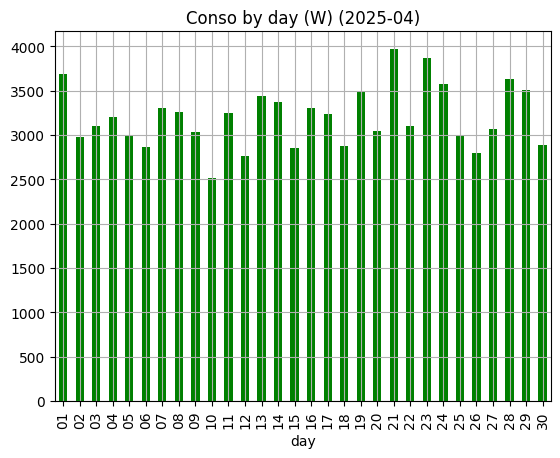

In [754]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [755]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3198.4)

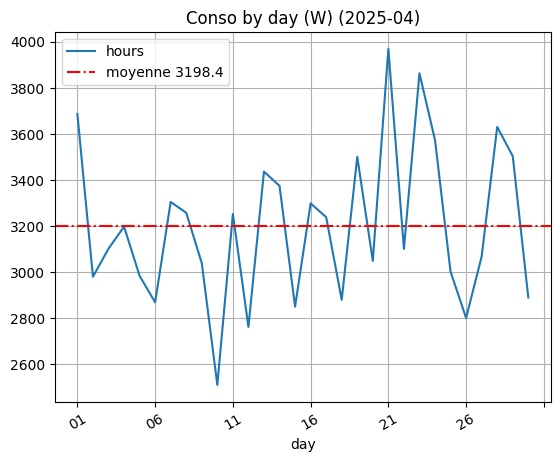

In [756]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [757]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

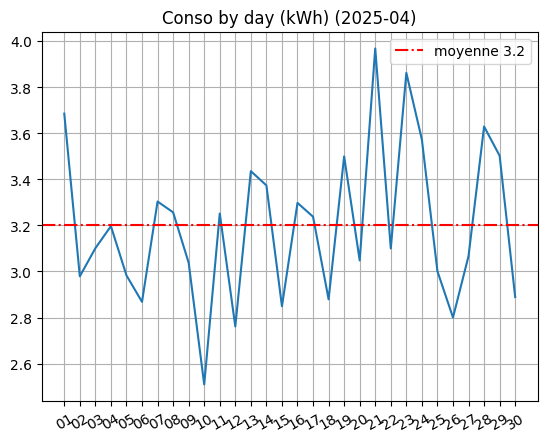

In [758]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [759]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [760]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [761]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,23957,23957,23957
2024-09,69921,69921,69921
2024-10,73355,73355,73355
2024-11,108176,108176,108176
2024-12,113985,113985,113985
2025-01,113848,113848,113848
2025-02,104372,104372,104372
2025-03,111791,111791,111791
2025-04,95952,95952,95952


In [762]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [763]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [764]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
25/08/24,1078
26/08/24,3832
27/08/24,3950
28/08/24,3749
29/08/24,4039
...,...
29/06/25,2290
30/06/25,2773
01/07/25,3652


In [765]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,3185,1.13,3.185,1130.298273,3185,2024-08-25 18:55:07.144128,25/08/24,18,2024-08,25
1,3207,1.12,3.207,1122.544434,6392,2024-08-25 18:55:10.351128,25/08/24,18,2024-08,25
2,6133,0.59,6.133,586.988423,12525,2024-08-25 18:55:16.484128,25/08/24,18,2024-08,25
3,3173,1.13,3.173,1134.572959,15698,2024-08-25 18:55:19.657128,25/08/24,18,2024-08,25
4,3178,1.13,3.178,1132.787917,18876,2024-08-25 18:55:22.835128,25/08/24,18,2024-08,25
...,...,...,...,...,...,...,...,...,...,...
999995,30066,0.12,30.066,119.736580,26919965856,2025-07-03 08:41:09.815128,03/07/25,08,2025-07,03
999996,29955,0.12,29.955,120.180270,26919995811,2025-07-03 08:41:39.770128,03/07/25,08,2025-07,03
999997,30041,0.12,30.041,119.836224,26920025852,2025-07-03 08:42:09.811128,03/07/25,08,2025-07,03
999998,29894,0.12,29.894,120.425503,26920055746,2025-07-03 08:42:39.705128,03/07/25,08,2025-07,03


In [766]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
25/08/24 18    0       25/08/24    18  1.13
               1       25/08/24    18  1.12
               2       25/08/24    18  0.59
               3       25/08/24    18  1.13
               4       25/08/24    18  1.13
...                         ...   ...   ...
03/07/25 08    999995  03/07/25    08  0.12
               999996  03/07/25    08  0.12
               999997  03/07/25    08  0.12
               999998  03/07/25    08  0.12
               999999  03/07/25    08  0.12

[1000000 rows x 3 columns]

In [767]:
groupallbyday.indices.keys()

dict_keys(['25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/1

In [768]:
groupallbydayhours.indices.keys()

dict_keys([('25/08/24', '18'), ('25/08/24', '19'), ('25/08/24', '20'), ('25/08/24', '21'), ('25/08/24', '22'), ('25/08/24', '23'), ('26/08/24', '18'), ('26/08/24', '19'), ('26/08/24', '20'), ('26/08/24', '21'), ('26/08/24', '22'), ('26/08/24', '23'), ('26/08/24', '00'), ('26/08/24', '01'), ('26/08/24', '02'), ('26/08/24', '03'), ('26/08/24', '04'), ('26/08/24', '05'), ('26/08/24', '06'), ('26/08/24', '07'), ('26/08/24', '08'), ('26/08/24', '09'), ('26/08/24', '10'), ('26/08/24', '11'), ('26/08/24', '12'), ('26/08/24', '13'), ('26/08/24', '14'), ('26/08/24', '15'), ('26/08/24', '16'), ('26/08/24', '17'), ('27/08/24', '18'), ('27/08/24', '19'), ('27/08/24', '20'), ('27/08/24', '21'), ('27/08/24', '22'), ('27/08/24', '23'), ('27/08/24', '00'), ('27/08/24', '01'), ('27/08/24', '02'), ('27/08/24', '03'), ('27/08/24', '04'), ('27/08/24', '05'), ('27/08/24', '06'), ('27/08/24', '07'), ('27/08/24', '08'), ('27/08/24', '09'), ('27/08/24', '10'), ('27/08/24', '11'), ('27/08/24', '12'), ('27/08/2

In [769]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
25/08/24,1078,1078
26/08/24,3832,3832
27/08/24,3950,3950
28/08/24,3749,3749
29/08/24,4039,4039
...,...,...
29/06/25,2290,2290
30/06/25,2773,2773
01/07/25,3652,3652


In [770]:
grp_by_day['kWh'].cumsum()

days
25/08/24       1078
26/08/24       4910
27/08/24       8860
28/08/24      12609
29/08/24      16648
             ...   
29/06/25     989417
30/06/25     992190
01/07/25     995842
02/07/25     999034
03/07/25    1000000
Name: kWh, Length: 313, dtype: int64

In [771]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
25/08/24 18      81
         19     253
         20     208
         21     194
         22     170
...             ...
03/07/25 04     103
         05      98
         06     107
         07     105
         08     131

[7479 rows x 1 columns]

In [772]:
grp_by_dayhours['kWh'].cumsum()

days      hours
25/08/24  18            81
          19           334
          20           542
          21           736
          22           906
                    ...   
03/07/25  04        999559
          05        999657
          06        999764
          07        999869
          08       1000000
Name: kWh, Length: 7479, dtype: int64

In [773]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
25/08/24 18      81      81    NaN
         19     253     334  172.0
         20     208     542  -45.0
         21     194     736  -14.0
         22     170     906  -24.0
...             ...     ...    ...
03/07/25 04     103     525    2.0
         05      98     623   -5.0
         06     107     730    9.0
         07     105     835   -2.0
         08     131     966   26.0

[7479 rows x 3 columns]

In [774]:
today, grp_by_dayhours.loc[today]

('03/07/25',
        kWh  cumsum  diff
 hours                   
 00     114     114   NaN
 01     106     220  -8.0
 02     101     321  -5.0
 03     101     422   0.0
 04     103     525   2.0
 05      98     623  -5.0
 06     107     730   9.0
 07     105     835  -2.0
 08     131     966  26.0)

Text(0.5, 1.0, 'Cumul journalier')

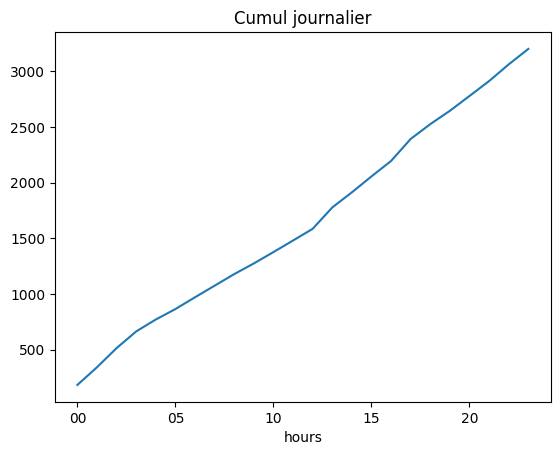

In [775]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

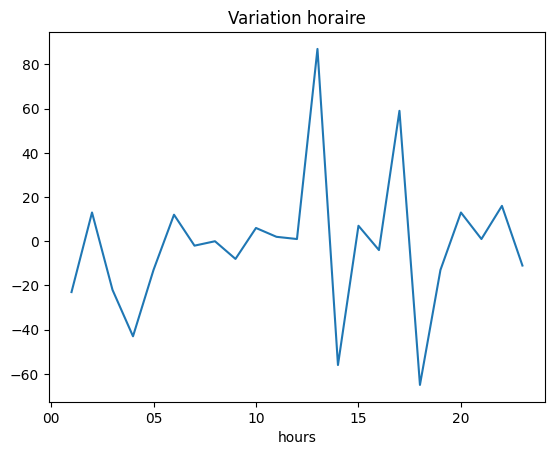

In [776]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [777]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

313

In [778]:
df_grp.tail(n)['kWh'].describe()


count    313.000000
mean       3.194888
std        0.753888
min        0.966000
25%        2.879000
50%        3.374000
75%        3.686000
max        4.747000
Name: kWh, dtype: float64

In [779]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [780]:
n, np.nanmean(df_grp.tail(n))

(313, np.float64(3.194888178913738))

Text(0.5, 1.0, '313 days')

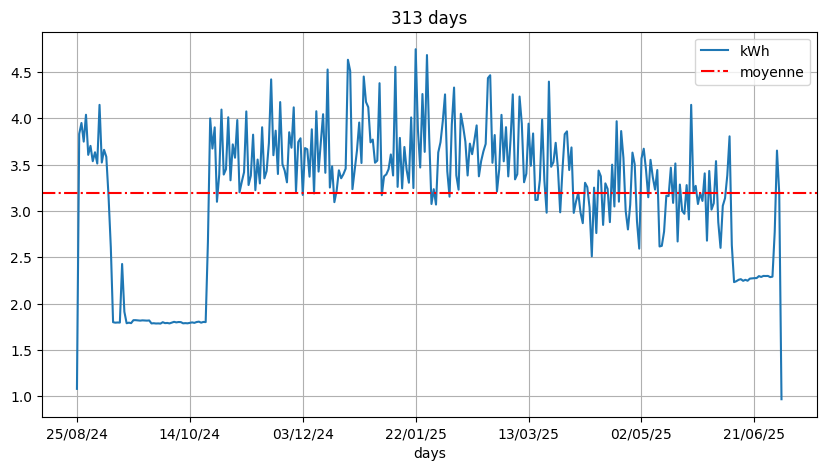

In [781]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

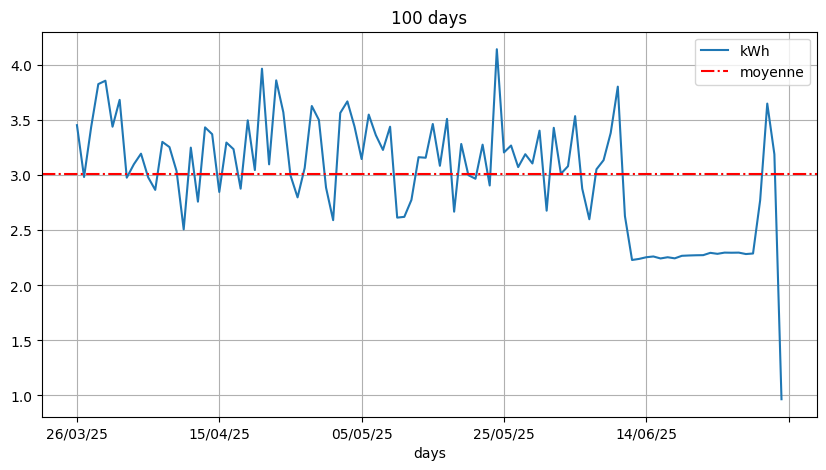

In [782]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [783]:
np.nanmean(df_grp.tail(span))

np.float64(3.0160700000000005)

In [784]:
df_grp['kWh']

days
25/08/24    1.078
26/08/24    3.832
27/08/24    3.950
28/08/24    3.749
29/08/24    4.039
            ...  
29/06/25    2.290
30/06/25    2.773
01/07/25    3.652
02/07/25    3.192
03/07/25    0.966
Name: kWh, Length: 313, dtype: float64

In [785]:
df_grp.describe()

,kWh
count,313.000000
mean,3.194888
std,0.753888
min,0.966000
25%,2.879000
50%,3.374000
75%,3.686000
max,4.747000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

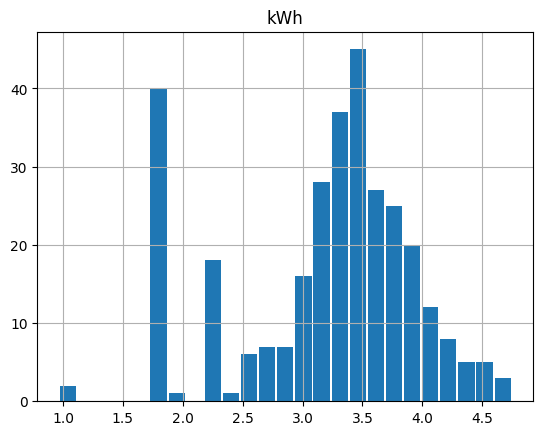

In [786]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [787]:
df_grp.tail(span)['kWh']

days
26/03/25    3.456
27/03/25    2.985
28/03/25    3.440
29/03/25    3.829
30/03/25    3.860
            ...  
29/06/25    2.290
30/06/25    2.773
01/07/25    3.652
02/07/25    3.192
03/07/25    0.966
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [788]:
day

'03/07/25'

In [789]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,114,114,NaN
01,106,220,-8.0
02,101,321,-5.0
03,101,422,0.0
04,103,525,2.0
05,98,623,-5.0
06,107,730,9.0
07,105,835,-2.0
08,131,966,26.0


In [790]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


9

In [791]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 10)

In [792]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [793]:
grp_by_dayhours.loc[day,'days'].values

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [794]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [795]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [796]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 00 to 08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     9 non-null      int64  
 1   cumsum  9 non-null      int64  
 2   diff    8 non-null      float64
 3   days    9 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 360.0+ bytes


In [797]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [798]:
day

'03/07/25'

In [799]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,114,114,NaN,1.0
01,106,220,-8.0,2.0
02,101,321,-5.0,3.0
03,101,422,0.0,4.0
04,103,525,2.0,5.0
05,98,623,-5.0,6.0
06,107,730,9.0,7.0
07,105,835,-2.0,8.0
08,131,966,26.0,9.0


In [800]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_6040\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(0.9660000000000001)

In [801]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
25/08/24 18      81      81    NaN   NaN
         19     253     334  172.0   NaN
         20     208     542  -45.0   NaN
         21     194     736  -14.0   NaN
         22     170     906  -24.0   NaN
...             ...     ...    ...   ...
03/07/25 04     103     525    2.0   5.0
         05      98     623   -5.0   6.0
         06     107     730    9.0   7.0
         07     105     835   -2.0   8.0
         08     131     966   26.0   9.0

[7479 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '03/07/25: kWh    0.966\ndtype: float64')

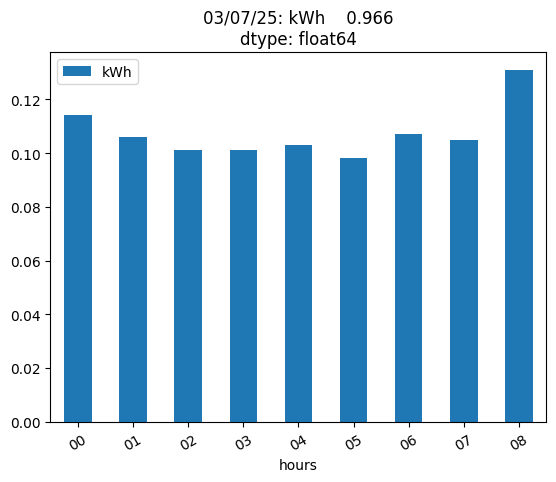

In [802]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [803]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08'], dtype='object', name='hours')

# Conso du jour


In [804]:
grp_by_dayhours.count()

kWh       7479
cumsum    7479
diff      7166
days         9
dtype: int64

'22/01/25'

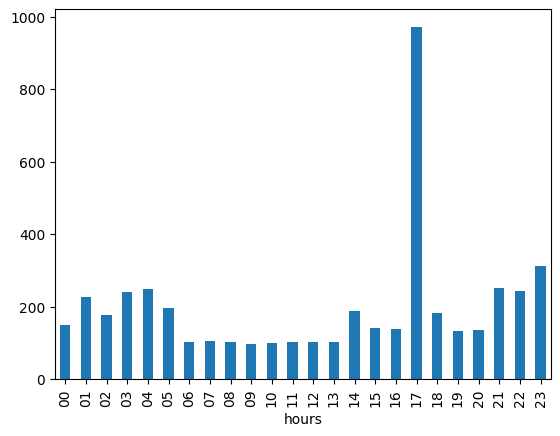

In [805]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [806]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 301.607 , Moyenne= 3.0160700000000005


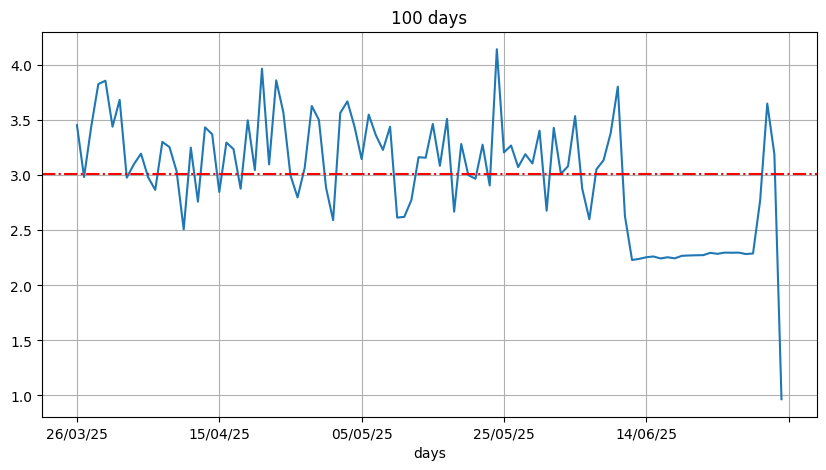

In [807]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [808]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 08:44:45, Minutes in day: 524


In [809]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [810]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:40.84


In [811]:
end - start

100.84253644943237

In [812]:
#df = conso_day
show_tranches()

1
2025-07-03 00:00:11.002128	2025-07-03 08:43:09.606128	8h 42m 58s 	966


In [813]:
df_grp.tail(7)['kWh']

days
27/06/25    2.298
28/06/25    2.285
29/06/25    2.290
30/06/25    2.773
01/07/25    3.652
02/07/25    3.192
03/07/25    0.966
Name: kWh, dtype: float64

<Axes: xlabel='days'>

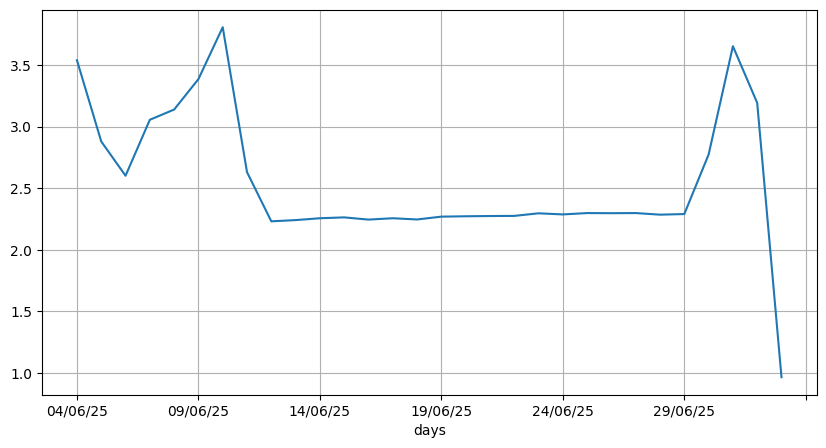

In [814]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

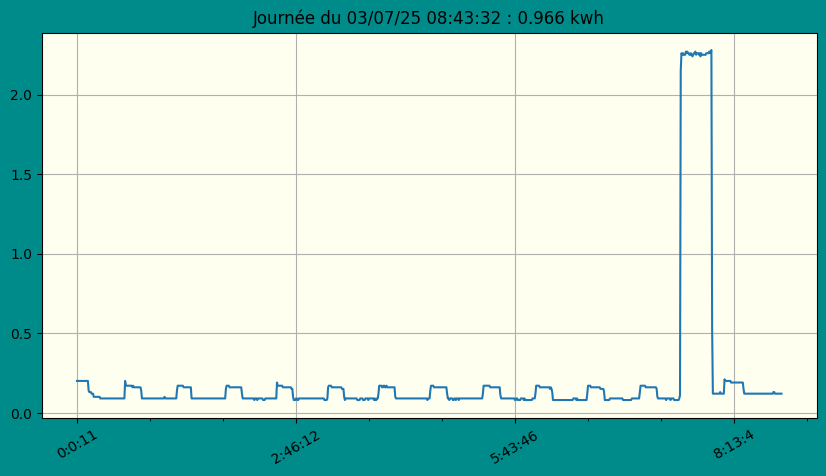

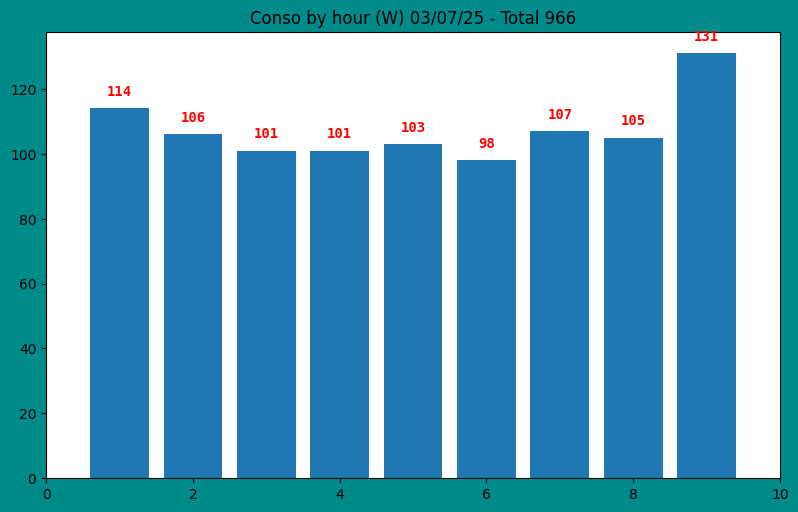

In [815]:
show(today,bgcolor='ivory')
conso_by_hour(today)

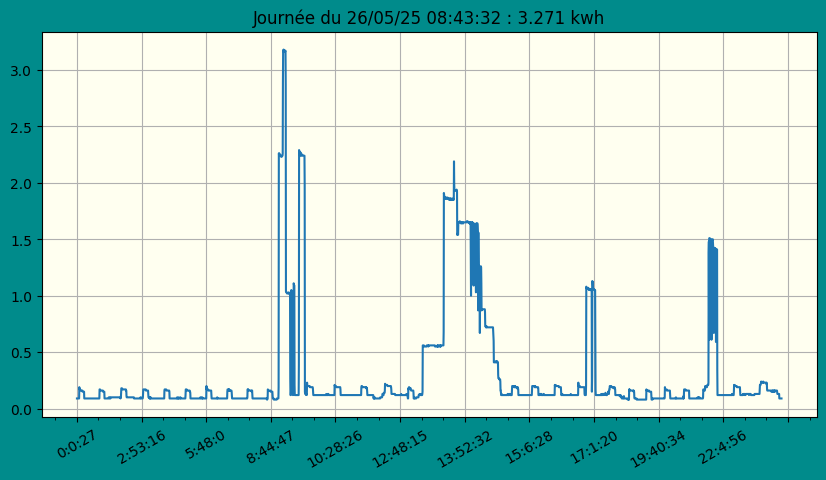

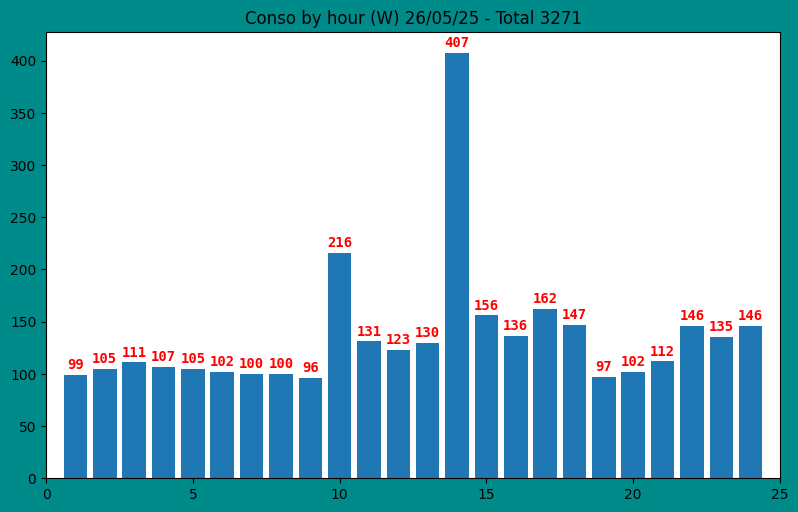

In [816]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4747)

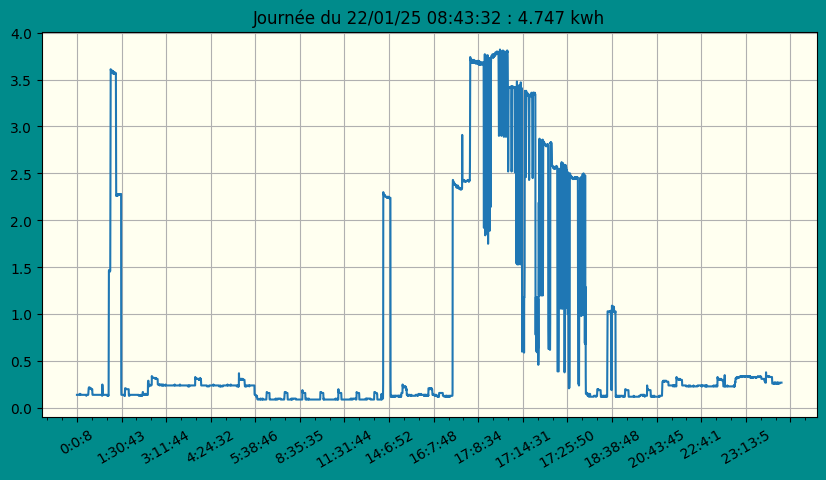

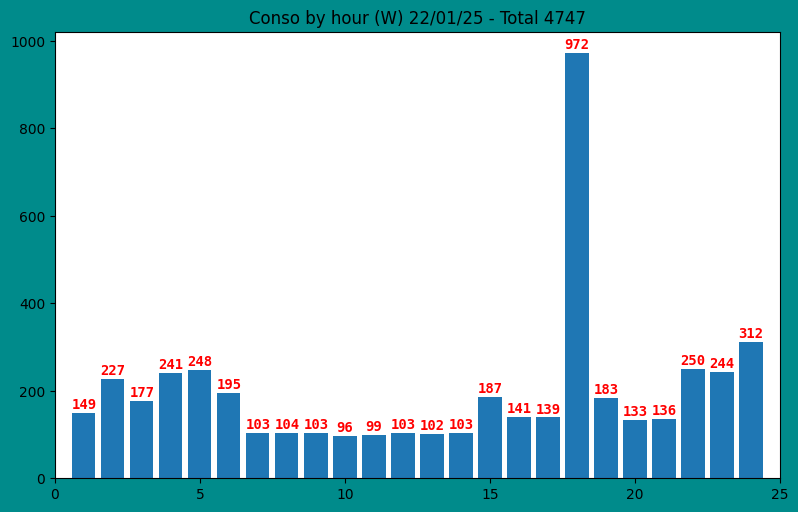

In [817]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

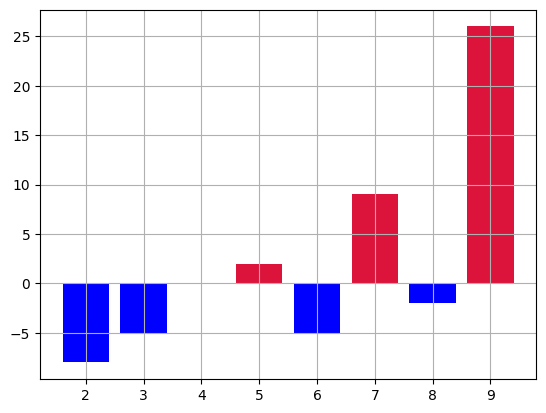

In [818]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

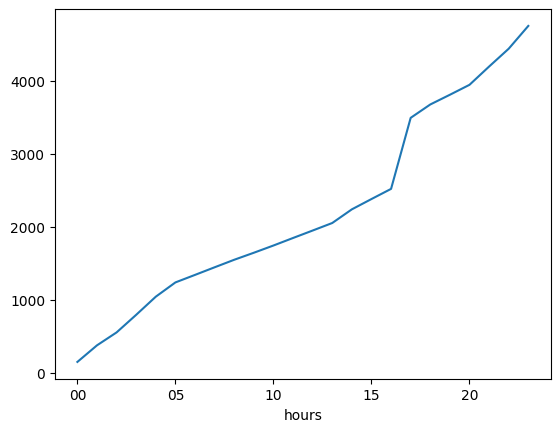

In [819]:
data.cumsum().plot()


<Axes: xlabel='hours'>

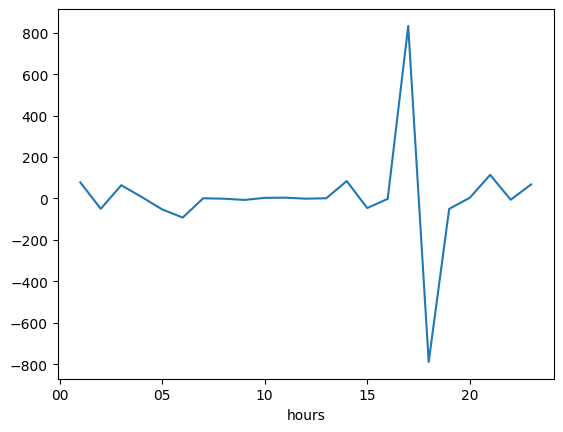

In [820]:
# evolution par heure
data.diff().plot()

In [821]:
data.diff().describe()

count     23.000000
mean       7.086957
std      249.424412
min     -789.000000
25%      -26.500000
50%        1.000000
75%       35.500000
max      833.000000
Name: kWh, dtype: float64

<Axes: >

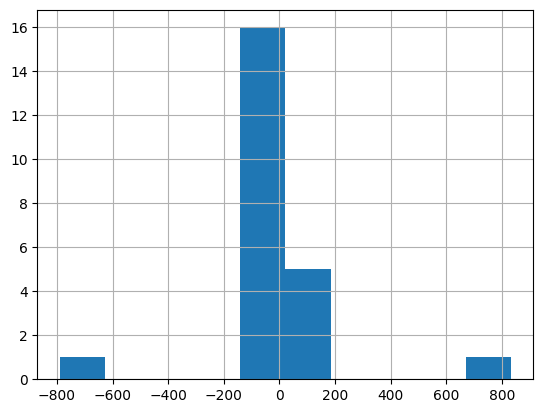

In [822]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [823]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [824]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

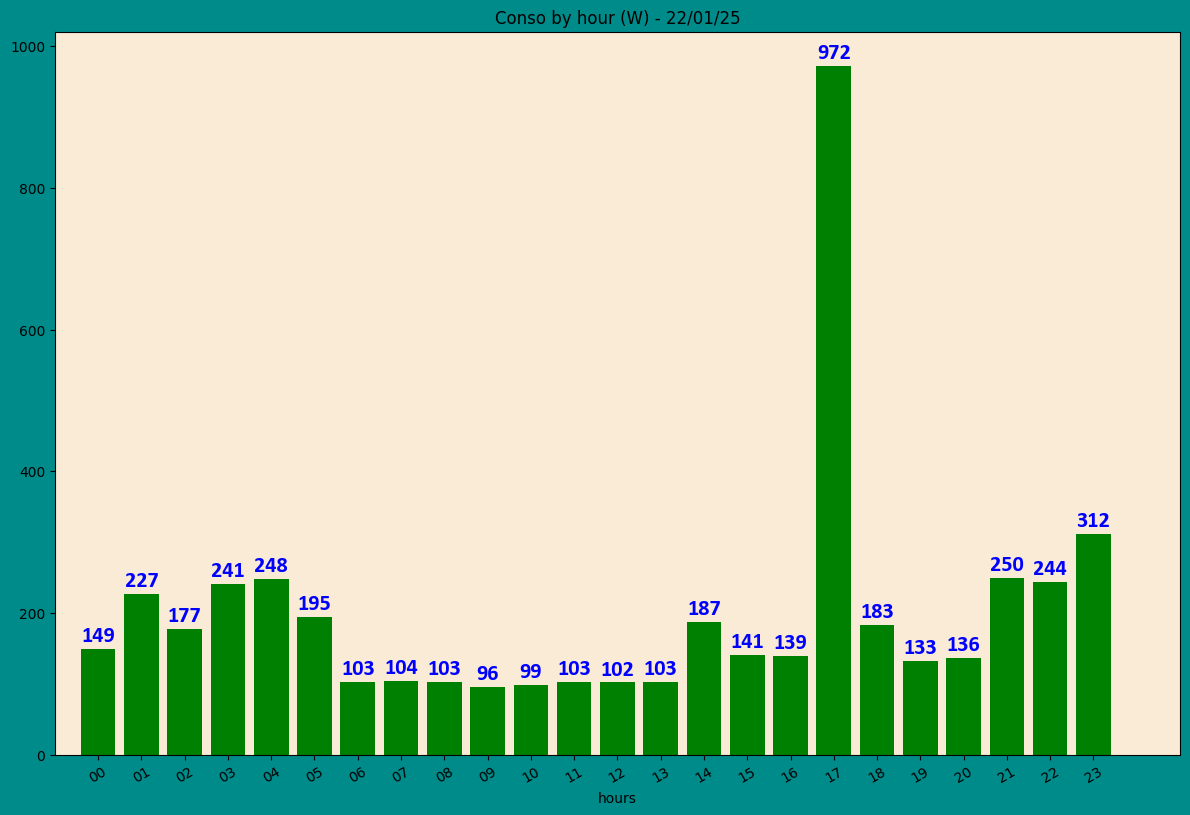

In [825]:
day,conso_byhour(day)

In [826]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


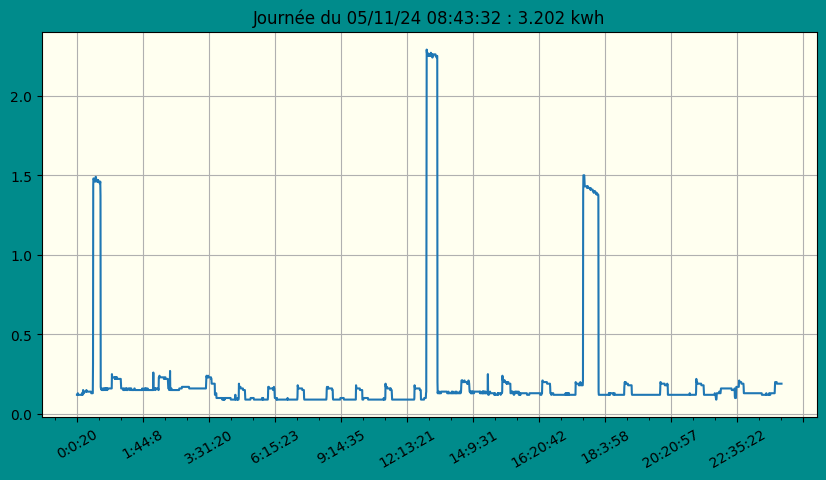

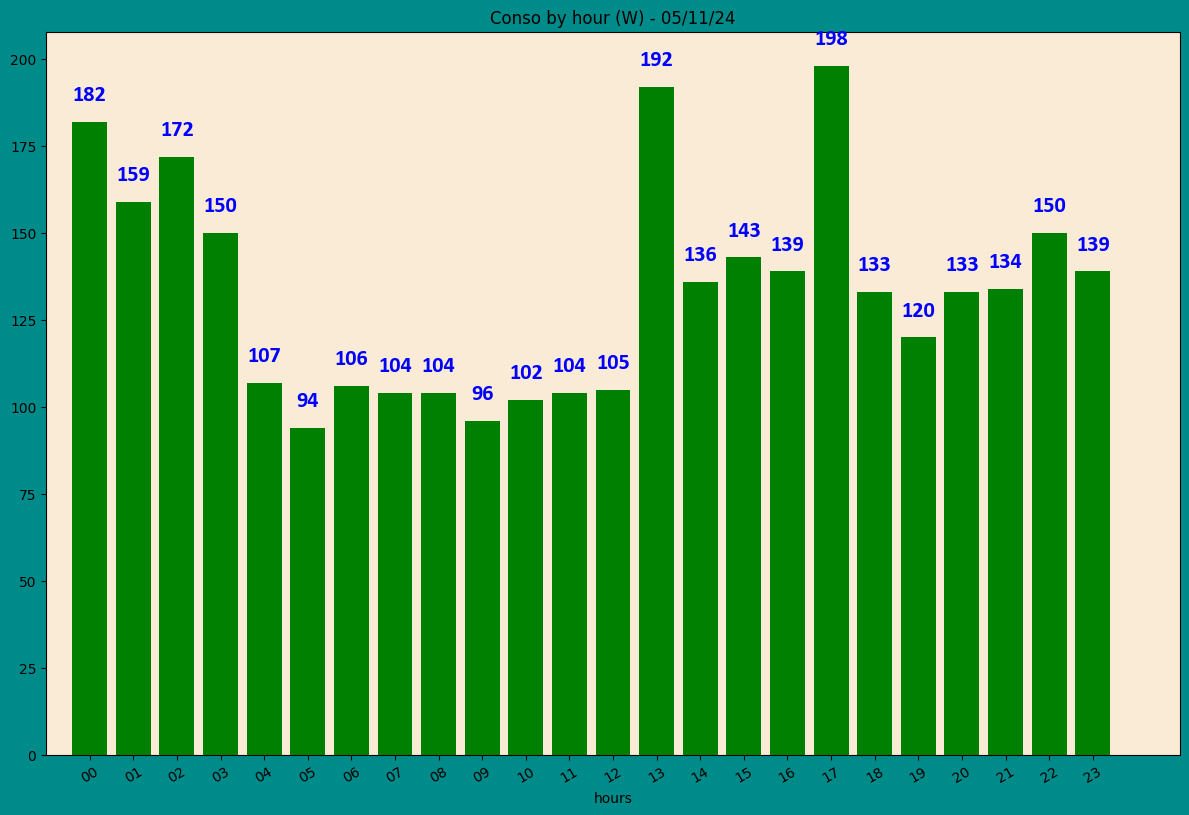

In [827]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [828]:
month

,day,hours,months,kWh
719405,01,00,2025-04,0.21
719406,01,00,2025-04,0.21
719407,01,00,2025-04,0.21
719408,01,00,2025-04,0.21
719409,01,00,2025-04,0.21
...,...,...,...,...
815352,30,23,2025-04,0.09
815353,30,23,2025-04,0.09
815354,30,23,2025-04,0.09
815355,30,23,2025-04,0.09


In [829]:
month.describe()


,kWh
count,95952.000000
mean,0.310167
std,0.547522
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

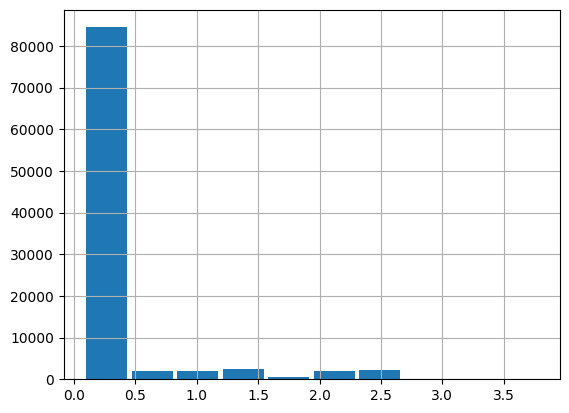

In [830]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

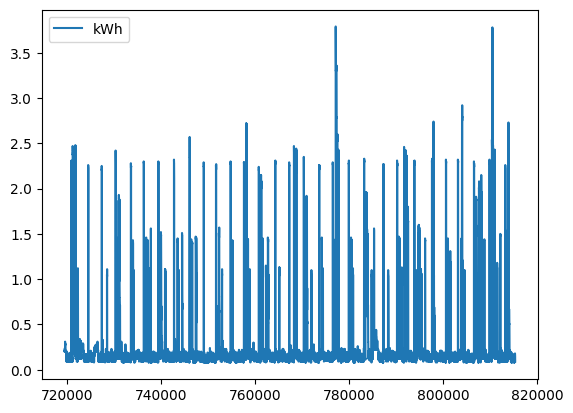

In [831]:
month.plot()

In [832]:
# index with max conso in this month
month.idxmax().kWh

np.int64(777162)

In [833]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       812468
hours     722911
months    719405
kWh       777162
dtype: int64

In [834]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [835]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
25/08/24 18      81      81    NaN   NaN
         19     253     334  172.0   NaN
         20     208     542  -45.0   NaN
         21     194     736  -14.0   NaN
         22     170     906  -24.0   NaN
...             ...     ...    ...   ...
03/07/25 04     103     525    2.0   5.0
         05      98     623   -5.0   6.0
         06     107     730    9.0   7.0
         07     105     835   -2.0   8.0
         08     131     966   26.0   9.0

[7479 rows x 4 columns]

In [836]:
month

,day,hours,months,kWh
719405,01,00,2025-04,0.21
719406,01,00,2025-04,0.21
719407,01,00,2025-04,0.21
719408,01,00,2025-04,0.21
719409,01,00,2025-04,0.21
...,...,...,...,...
815352,30,23,2025-04,0.09
815353,30,23,2025-04,0.09
815354,30,23,2025-04,0.09
815355,30,23,2025-04,0.09


In [837]:
month.idxmax()


day       812468
hours     722911
months    719405
kWh       777162
dtype: int64

In [838]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 777162, dtype: object

In [839]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       165
          01       182
          02       154
          03       114
          04       102
          05       108
          06       111
          07       111
          08        98
          09       110
          10       111
          11       109
          12       172
          13       144
          14       149
          15       146
          16       192
          17       143
          18       196
          19       158
          20       149
          21       143
          22       158
          23       226
Name: kWh, dtype: int64

In [840]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'23'

<Axes: xlabel='days,hours'>

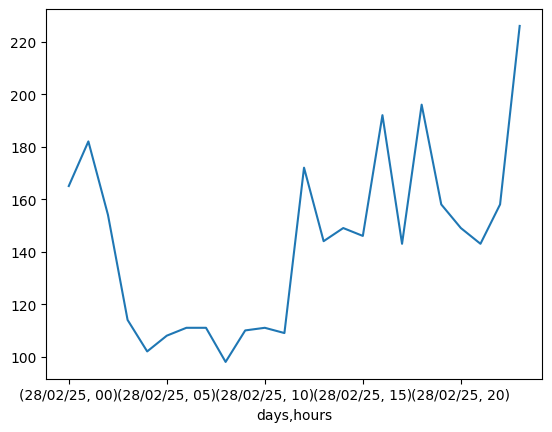

In [841]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [842]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [843]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [844]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [845]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB